In [24]:
using SparseIR
using PyPlot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"
using LinearAlgebra
using Revise
using Optim
using FFTW
#using ForwardDiff
using Zygote
using Flux
include("./src_Nevanlinna.jl")

calc_functional (generic function with 3 methods)

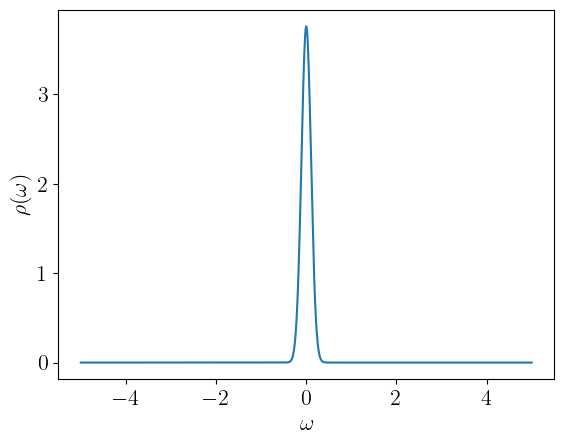

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x14aa2e143f70>

In [2]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)

#rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

rho(omega) = gaussian(omega, 0.0, 0.15)
#    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)


omegas = LinRange(-5, 5, 1000)
plt.xlabel(L"\omega")
plt.ylabel(L"\rho(\omega)")
plt.plot(omegas, rho.(omegas))

In [3]:
beta = 100
wmax = 1000
IR_basis_set = FiniteTempBasisSet(beta, wmax, 1e-7)
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:size(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* rhol
;
#=
plt.semilogy(abs.(rhol), marker="o", label=L"|\rho_l|")
plt.semilogy(abs.(gl), marker="x", label=L"|g_l|")
plt.xlabel(L"l")
plt.ylim([1e-5, 1])
#plt.legend()
=#

In [4]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = Int64(length(IR_basis_set.smpl_wn_f.sampling_points)/2)

37

In [5]:
setprecision(128)

128

In [6]:
test_gw   = Array{Complex{BigFloat}}(undef, hnw) 
test_smpl = Array{BigFloat}(undef, hnw) 
;

In [7]:
for i in 1:hnw
    test_smpl[i]= parse(BigFloat, string(IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta))
    test_gw[i]  = parse(BigFloat, string(real(gw[hnw+i]))) + parse(BigFloat, string(imag(gw[hnw+i])))*im
end

In [8]:
N_imag    =  12
N_real    =  6000
omega_min = -10.0
omega_max =  10.0
eta       =  0.001
H         =  1
ab_coeff = zeros(Float64, 2*H) 
imaginary = ImagDomainData(N_imag, test_smpl, test_gw)
phis = calc_phis(imaginary)

pre_reals = RealDomainData(N_real, omega_min, omega_max, eta)
pre_abcd = calc_abcd(imaginary, pre_reals, phis)
evaluation(imaginary, pre_reals, pre_abcd, H, ab_coeff)

reals = RealDomainData(N_real, omega_min, omega_max, eta)
abcd = calc_abcd(imaginary, pre_reals, phis)
evaluation(imaginary, reals, abcd, H, ab_coeff)
;

Pick matrix is positive semi-definite.


In [9]:
#=
N_imag    =  12
N_real    =  6000
omega_min = -10.0
omega_max =  10.0
eta       =  0.001
H         =  1
ab_coeff = zeros(Float64, 2*H) 
imaginary = ImagDomainData(N_imag, test_smpl, test_gw)
phis = calc_phis(imaginary)
pre_reals = RealDomainData(N_real, omega_min, omega_max, eta)
evaluation(imaginary, pre_reals, phis, H, ab_coeff)
reals = RealDomainData(N_real, omega_min, omega_max, eta)
evaluation(imaginary, reals, phis, H, ab_coeff)
=#
;

In [10]:
calc_functional(pre_reals)

1.1091237790523654

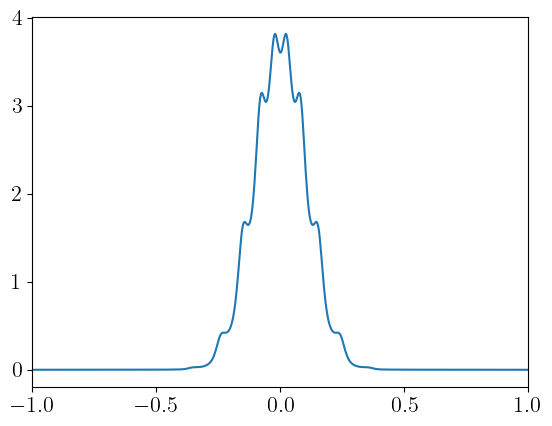

(-1.0, 1.0)

In [11]:
plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(-1.0,1.0)

In [16]:
function functional(imag::ImagDomainData, reals::RealDomainData, phis::Vector{Complex{BigFloat}}, H::Int64, ab_coeff::Vector{Float64})
    evaluation(imaginary, reals, phis, H, ab_coeff)
    return real(calc_functional(reals))
end
function functional(imag::ImagDomainData, reals::RealDomainData, abcd::Array{Complex{BigFloat},3}, H::Int64, ab_coeff::Vector{Float64})
    evaluation(imaginary, reals, abcd, H, ab_coeff)
    return real(calc_functional(reals))
end

functional (generic function with 2 methods)

In [25]:
#ff = x->functional(imaginary, reals, phis, H, x)
ff = x->calc_functional(reals, abcd, H, x)

#15 (generic function with 1 method)

In [26]:
gradient(ff, ab_coeff)

LoadError: InterruptException:

In [48]:
@time res = optimize(ff, ab_coeff, BFGS())
#@time res = optimize(ff, ab_coeff, ConjugateGradient())

LoadError: InterruptException:

In [49]:
evaluation(imaginary, reals, phis, H, Optim.minimizer(res))

LoadError: UndefVarError: res not defined

In [50]:
println(res)

LoadError: UndefVarError: res not defined

In [51]:
param_f = open( "optim_param.dat", "w")
for i in 1:2*H
    println(param_f, "$(Optim.minimizer(res)[i])")
end
close(param_f)

LoadError: UndefVarError: res not defined

In [52]:
plt.plot(Float64.(real.((reals.freq))), Float64.(imag.(reals.val))/pi)
plt.plot(Float64.(real.((pre_reals.freq))), Float64.(imag.(pre_reals.val))/pi)
plt.xlim(-1.0,1.0)

Figure(PyObject <Figure size 640x480 with 1 Axes>)

(-1.0, 1.0)

In [53]:
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()

LoadError: InterruptException:

In [54]:
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#